## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,classification_report ,roc_curve, auc ,precision_recall_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet169, ResNet50V2, EfficientNetB2, InceptionV3, VGG16
from tensorflow.keras.activations import swish 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

In [5]:
train_path = 'chest-xray-pneumonia/chest_xray/train'
test_path  = 'chest-xray-pneumonia/chest_xray/test'
val_path   = 'input/chest-xray-pneumonia/chest_xray/val'

labels =['NORMAL' ,'PNEUMONIA']

- **Show some images from each class**

NORMAL : Class number 0 , that contain 1341 image


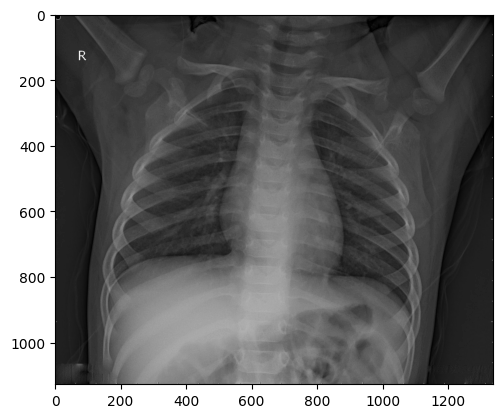

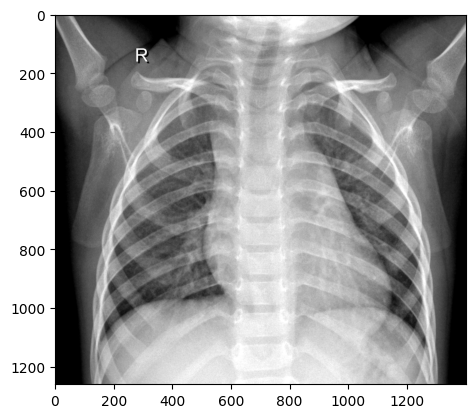

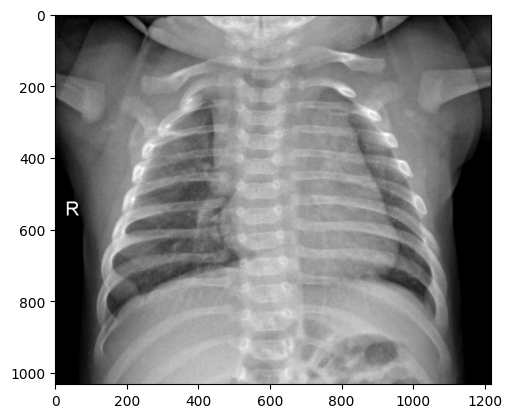

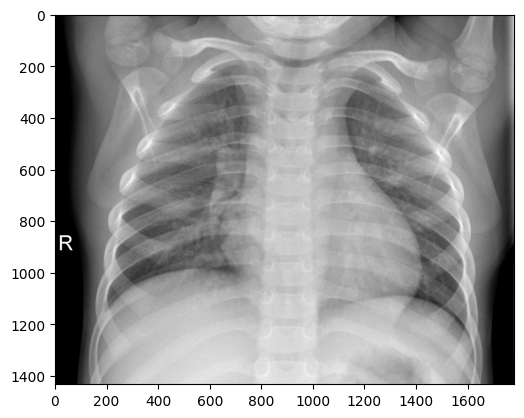

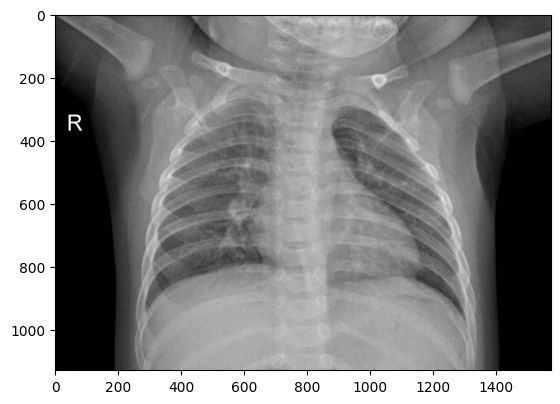

PNEUMONIA : Class number 1 , that contain 3875 image


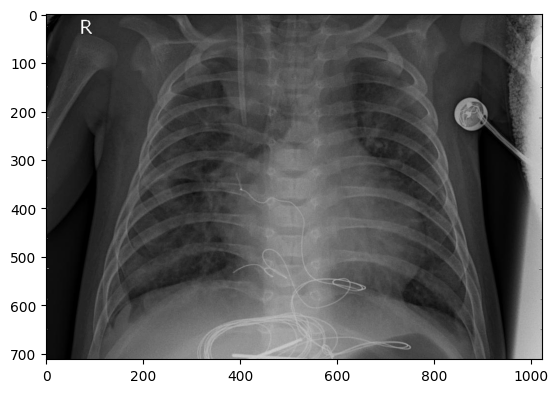

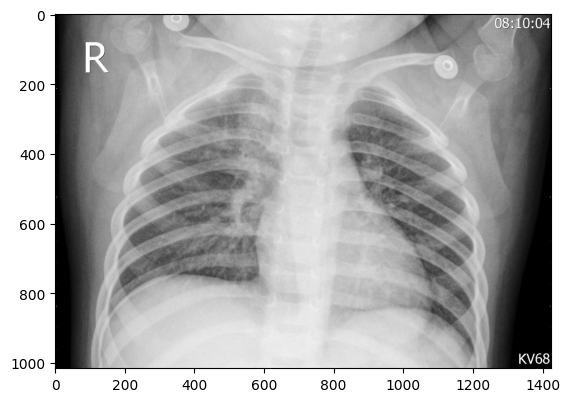

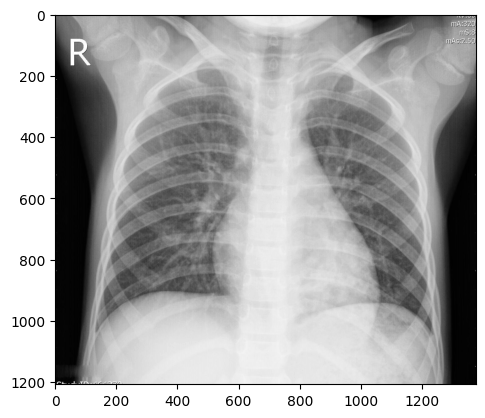

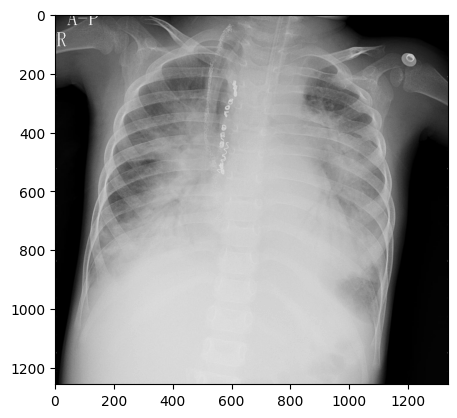

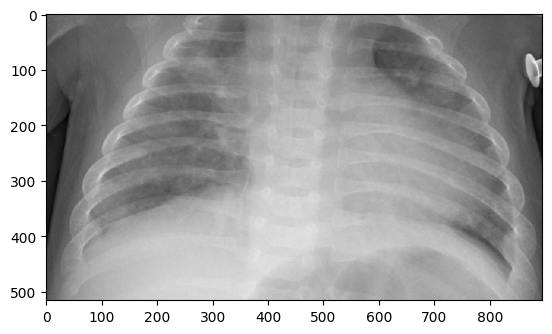

In [6]:
i =0
counts = {}

for label in labels :
    path =os.path.join(train_path ,label)
    counts[label] = len(os.listdir(path))
    x =0
    print(f'{label} : Class number {i} , that contain {len(os.listdir(path))} image')
    for img in os.listdir(path):
        x +=1
        img =cv2.imread(os.path.join(path ,img) ,cv2.IMREAD_GRAYSCALE)
        plt.imshow(img ,cmap ='gray')
        plt.show()
        if x ==5 :
            print('=='*40)
            break
    i +=1

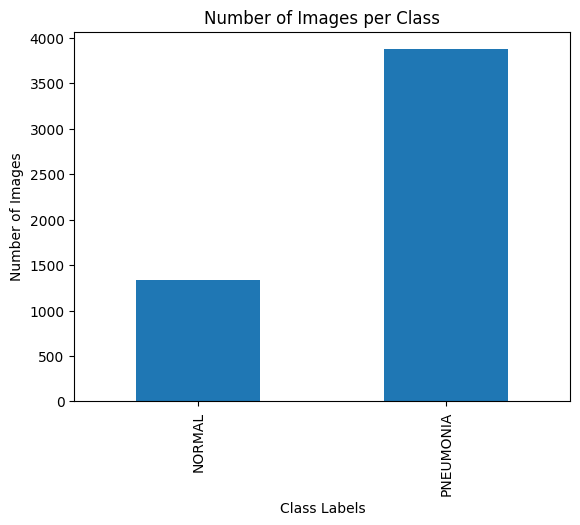

In [7]:
df = pd.DataFrame(list(counts.items()), columns=['Label', 'Count'])
df.set_index('Label', inplace=True)


df.plot(kind='bar', legend=False)

plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [8]:
img.shape

(516, 895)

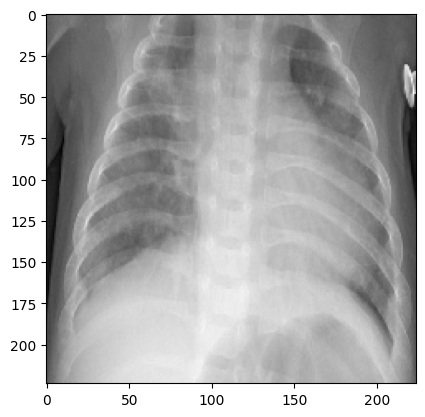

In [9]:
img_size =224

resized_img =cv2.resize(img ,(img_size ,img_size) ,1)
plt.imshow(resized_img ,cmap ='gray')
plt.show()

In [10]:
img.max(), img.min()

(208, 0)

## Training Data

In [11]:
train_generator=ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_directory(train_path,
                      batch_size=32,
                      target_size=(img_size, img_size),
                      subset="training",
                      color_mode='rgb', 
                      class_mode='binary', 
                      shuffle=True)

Found 5216 images belonging to 2 classes.


In [12]:
labels=list(train_generator.class_indices.keys())
labels

['NORMAL', 'PNEUMONIA']

In [ ]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        #plt.title(labels[np.where(y_batch[i]==1)[0][0]])   # when y is categorical
        plt.title(labels[int(y_batch[i])])   # when y is binary or sparse
        plt.axis('off')
        plt.grid(None)
    # show the plot
    plt.show()
    break

## Validation & Testing

- we don't need to make augmentation on test or validation data so, i will normalized data only.

In [14]:
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
).flow_from_directory(test_path,
                      batch_size=32,
                      target_size=(img_size, img_size),
                      color_mode='rgb',
                      class_mode='binary',
                      shuffle=False)


val_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
).flow_from_directory(val_path,
                      batch_size=32,
                      target_size=(img_size, img_size),
                      color_mode='rgb',
                      class_mode='binary')

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Model Training

# Densenet

In [ ]:
size = (img_size, img_size, 3)
num_classes = len(labels)



# Load DenseNet169 with pre-trained ImageNet weights
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=size)

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

print(model.summary())

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

In [16]:
history = model.fit(
    train_generator,  
    validation_data=test_generator,  
    epochs=10,  
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 973ms/step - accuracy: 0.6747 - loss: 0.6722 - val_accuracy: 0.6394 - val_loss: 0.5774 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 557ms/step - accuracy: 0.7814 - loss: 0.4578 - val_accuracy: 0.7500 - val_loss: 0.4642 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 551ms/step - accuracy: 0.8431 - loss: 0.3397 - val_accuracy: 0.7788 - val_loss: 0.4389 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 559ms/step - accuracy: 0.8780 - loss: 0.2833 - val_accuracy: 0.8061 - val_loss: 0.4000 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 556ms/step - accuracy: 0.8988 - loss: 0.2490 - val_accuracy: 0.8109 - val_loss: 0.3898 - learning_rate: 1.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 545ms/step - accuracy: 0.8988 - loss: 0.2354 - val_accuracy: 0.8157 - val_loss: 0.3867 - learning_rate: 1.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 550ms/step -

In [17]:
model.save('densenet_pneumonia.h5')

In [24]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)
print('Test accuracy:', test_loss)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.7415 - loss: 0.5836
Test accuracy: 0.9463
Test accuracy: 0.3680664002895355


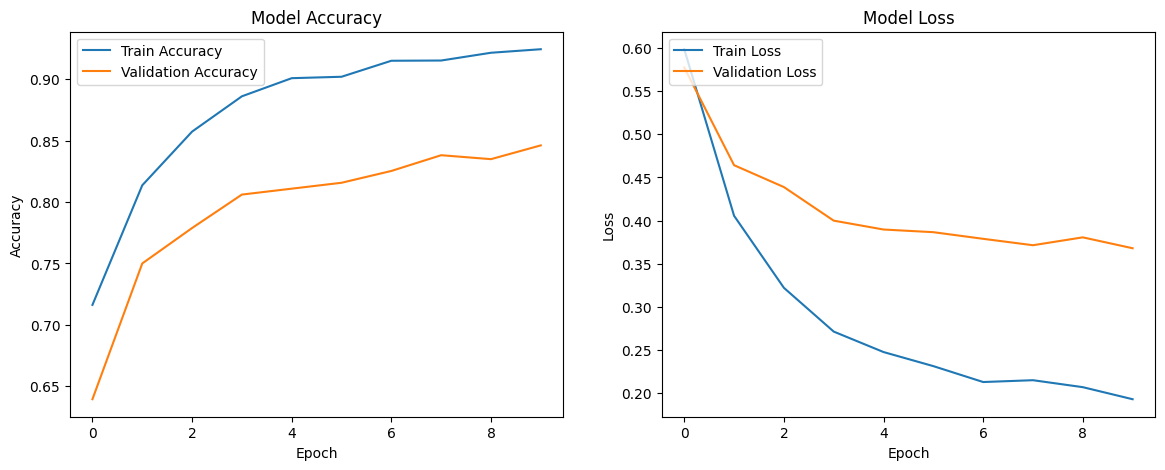

In [19]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


In [20]:
from sklearn.metrics import classification_report

# Predict on test data
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values

# Get true labels
y_true = test_generator.classes  

# Print classification report
print(classification_report(y_true, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 785ms/step
              precision    recall  f1-score   support

           0       0.90      0.67      0.76       234
           1       0.83      0.95      0.89       390

    accuracy                           0.85       624
   macro avg       0.86      0.81      0.83       624
weighted avg       0.85      0.85      0.84       624



20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step


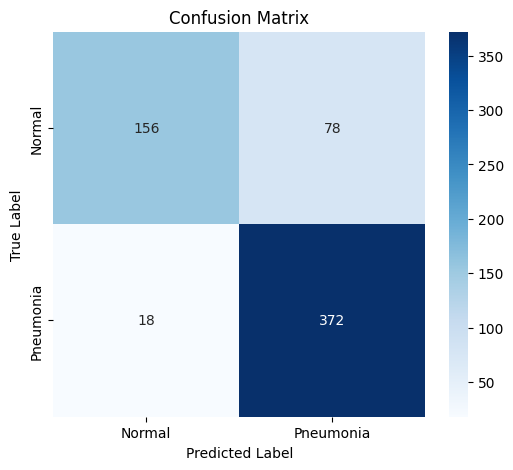

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on test data
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values

# Get true labels
y_true = test_generator.classes  

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Deployment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels from validation generator
val_images, val_labels = next(val_generator)  # Take one batch

# Predict labels
predictions = model.predict(val_images)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Get class names
class_names = ['Normal', 'Pneumonia']

# Plot images with prediction results
plt.figure(figsize=(12, 8))
for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(val_images[i], cmap='gray')  # Display image
    
    true_label = class_names[int(val_labels[i])]  # Fixed indexing
    predicted_label = class_names[int(predicted_labels[i])]
    
    # Check if prediction is correct
    correctness = "Correct" if true_label == predicted_label else "Incorrect"
    
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}\n{correctness}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<ipython-input-23-d3628e5072bd>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_names[int(predicted_labels[i])]


# user prediction

In [29]:
import numpy as np
import tensorflow as tf
from PIL import Image
import tensorflow.keras.preprocessing.image as keras_image

# Load the trained model (ensure this file is in your working directory)
model = tf.keras.models.load_model(r"C:\Users\moham\OneDrive\Desktop\Pneumonia_Detection\project frontend\densenet_pneumonia.h5")

# Class labels
class_names = ['Normal', 'Pneumonia']

# Input size expected by the model
img_size = 224  # Change if your model expects a different size

# Prediction function
def predict_image(img_path):
    try:
        # Load and preprocess the image
        img = Image.open(img_path).convert("RGB")  # Convert image to RGB to remove alpha channel
        img = img.resize((img_size, img_size))  # Resize image to match model's expected size
        img_array = np.array(img)  # Convert to numpy array
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

        # Model prediction
        prediction = model.predict(img_array)[0][0]
        predicted_label = class_names[1] if prediction > 0.5 else class_names[0]

        print(f"Model Prediction: {predicted_label}")

    except Exception as e:
        print(f"Error: {e}")

# Example usage:
# Replace this path with the actual path to your image
image_path = r"C:\Users\moham\OneDrive\Desktop\Pneumonia_Detection\Testing 3\p8.png"
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Model Prediction: Pneumonia


In [13]:
from PIL import Image
img = Image.open(r"C:\Users\moham\OneDrive\Desktop\Pneumonia_Detection\Testing 3\n1.png")
img.show()


In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load trained model
model = tf.keras.models.load_model("densenet_pneumonia.h5")  # Change to your model path

# Class labels (Modify if needed)
class_names = ['Normal', 'Pneumonia']

# Function to make predictions
def predict_image(img):
    img = img.resize((img_size, img_size))  # Resize image to model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    
    prediction = model.predict(img_array)[0][0]  # Get prediction score
    
    predicted_label = "Pneumonia" if prediction > 0.5 else "Normal"
    
    return f"Model Prediction: {predicted_label}"

# Create Gradio app
interface = gr.Interface(fn=predict_image, inputs="image", outputs="text")
interface.launch()